# COGS 108 - Final Project 

# Overview

This project looks at the average change in score for repeat inspections using visualizations such as histograms and plots. It obtains the difference in score for each restaurant from the earliest inspection to the most recent, and finds that the mean of these differences is -0.6. This leads to the conclusion that multiple inspections do not neccessarily have much of an affect on restaurant health scores.

# Name & GitHub

- Name: Zilu Zhu
- GitHub Username: A15454681, luluzhu9

# Research Question

For repeat inspections, what is the average change in score?

## Background and Prior Work

Base line resturant inspections are done twice a year, and are increased if a restaurant is flagged for having safety issues. Restaurants are scored from a 0-100 scale, with 100 being the maximum. There is not much research done on this specific research question, but there are studies that have similar aims.


References (include links):
- 1) https://www.techrepublic.com/article/google-and-harvard-test-a-machine-learning-approach-to-food-safety/

Google and Harvard conducted a study where they utilized a machine learning model called FINDER to predict which restaurants were unsafe quickly versus the standard health check routine, which is twice a year. FINDER would consider the symptoms of food poisoning, look through search queries that matched those symptoms, and use anonymous location data to find which restaurants those individuals visited. The result was that 50% of the restaurants FINDER flagged were indeed unsafe, versus 25% with the baseline inspections. This relates to this research project because it supports the idea that increasing the number of inspections has a positive affect on food safety. The FINDER study is more of a precaution study, while the research question I am examining is an after-caution; it looks at what could happen when inspections are increased after a restaurant is flagged.

- 2) https://www.sapanalytics.cloud/resources-visualizing-new-york-city-restaurant-inspections/

This study looked at New York City Open Data and plotted them in several graphs, such as the number of inspection versus number of citations each year, percent critical versus non-critical issues found, and percent inspections that resulted in a violation. This study had multiple takeaways, one of which was "initial inspections have much worse scores and grades than re-inspections". This also supports the idea that inspections after alerting a restaurant of its health issues does make a positive difference in their score. 

# Hypothesis


I predict that the average change in score for repeat inspections will be significantly positive for restaurants that did not recieve passing inspections on their first inspection, which differs from the restauarants that did obtain passing inspections on their first inspection. This is because once a restaurant is aware of its health issues and knows it is recieving more inspections, it would most likely pay more attention to improving its food safety to increase its score, while restaurants who have passed have no need to pay more attention.

# Dataset(s)

- Dataset Name: inspections.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/assignments/110486
- Number of observations: 18466

The inspections dataset contains information about every inspection case, including information such as the score obtained during that inspection, who inspected, when, and where. 

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# Read csv 
df_inspec = pd.read_csv('inspections.csv')

# Show all columns
pd.set_option('display.max_columns', None)
df_inspec.head()

,hsisid,date,name,address1,address2,city,state,postalcode,phonenumber,restaurantopendate,days_from_open_date,facilitytype,x,y,geocodestatus,zip,type,description,inspectedby,inspection_num,inspector_id,previous_inspection_date,days_since_previous_inspection,previous_inspection_by_same_inspector,score,num_critical,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,top_match,second_match,critical
0,4092013748,2012-09-21T00:00:00Z,Cafe 3000 At Wake Med,3000 New Bern Ave,NaN,raleigh,NC,27610,(919) 350-8047,2002-12-21T00:00:00Z,3562,Restaurant,-78.587963,35.783914,M,27610,Inspection,This facility cooks eggs to order in Grill sta...,Melissa Harrison,1,27.0,NaN,NaN,NaN,96.0,9,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,4092014046,2012-09-21T00:00:00Z,Overtime Sports Pub,1030-149 N Rogers Ln,NaN,raleigh,NC,27610,(919) 255-9556,2004-05-04T00:00:00Z,3062,Restaurant,-78.549673,35.791986,M,27610,Inspection,NaN,Christopher Walker,1,7.0,NaN,NaN,NaN,98.0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4092015191,2012-09-21T00:00:00Z,TASTE OF CHINA,6209 ROCK QUARRY RD,STE 126,raleigh,NC,27610,(919) 773-2285,2008-08-04T00:00:00Z,1509,Restaurant,-78.547960,35.723125,M,27610,Inspection,NaN,Anne Bartoli,1,3.0,NaN,NaN,NaN,97.0,4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4092016122,2012-09-21T00:00:00Z,Panera Bread #1643,1065 Darrington DR,NaN,cary,NC,27513,NaN,2012-03-28T00:00:00Z,177,Restaurant,-78.815727,35.799249,M,27513,Inspection,NaN,Lisa McCoy,1,24.0,NaN,NaN,NaN,99.0,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4092021513,2012-09-21T00:00:00Z,WalMart Supercenter #4499-00 Deli/Bakery,841 E Gannon AVE,NaN,zebulon,NC,27597,(919) 269-2221 ext. 304,2008-02-25T00:00:00Z,1670,Food Stand,-78.296347,35.831285,M,27597,Inspection,"New rules, www.wakegov.com/food",Christopher Walker,1,7.0,NaN,NaN,NaN,97.0,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [3]:
# Remove columns not used for analysis
df_inspec.drop(['city', 'state', 'postalcode', 'phonenumber', 
                'restaurantopendate','days_from_open_date', 'facilitytype', 'x', 'y', 'geocodestatus', 'zip', 'type', 
                'description', 'inspectedby', 'inspection_num', 'inspector_id', 'previous_inspection_date', 
                'days_since_previous_inspection', 'previous_inspection_by_same_inspector', 'num_critical',
                'num_non_critical', 'num_non_critical_previous', 'num_critical_mean_previous', 
                'num_non_critical_mean_previous', 'avg_neighbor_num_critical', 'avg_neighbor_num_non_critical', 
                'top_match', 'second_match', 'critical', 'num_critical_previous'], axis=1, inplace=True)

# Drop null values
df_inspec = df_inspec.dropna()
bool_series = pd.notnull(df_inspec)  
df_inspec[bool_series]

# View dataframe
df_inspec.head()

,hsisid,date,name,address1,address2,score
2,4092015191,2012-09-21T00:00:00Z,TASTE OF CHINA,6209 ROCK QUARRY RD,STE 126,97.0
12,4092013641,2012-09-25T00:00:00Z,California Pizza Kitchen,5959 Triangle Town Center RD,Ste 2121,96.0
32,4092011879,2012-09-27T00:00:00Z,El Dorado #8,8111 CREEDMOOR RD,ste.161,92.5
33,4092012937,2012-09-27T00:00:00Z,Pf Changs Restaurant,4325 Glenwood AVE,Suite 2089,92.5
39,4092015983,2012-09-27T00:00:00Z,Cariokos,1601 CROSS LINK RD,STE 43,97.0


In [4]:
# Change score's type from float to int
df_inspec['score'] = df_inspec['score'].apply(np.int64)

# Change date from object into datetime
df_inspec['date'] = pd.to_datetime(df_inspec['date'])

# Change name of hsisid to ID
df_inspec = df_inspec.rename({'hsisid': 'id'}, axis=1)

# Sort by name alphabetically to group together by name, then by date
df_inspec = df_inspec.sort_values(by=['name','date'])

# View dataframe
df_inspec.head()

,id,date,name,address1,address2,score
1551,4092014587,2013-02-28 00:00:00+00:00,18 Seaboard,18 Seaboard AVE,Ste. 100,97
3812,4092014587,2013-09-18 00:00:00+00:00,18 Seaboard,18 Seaboard AVE,Ste. 100,97
7492,4092014587,2014-08-27 00:00:00+00:00,18 Seaboard,18 Seaboard AVE,Ste. 100,97
10696,4092014587,2015-04-30 00:00:00+00:00,18 Seaboard,18 Seaboard AVE,Ste. 100,93
12792,4092014587,2015-09-29 00:00:00+00:00,18 Seaboard,18 Seaboard AVE,Ste. 100,97


# Data Analysis & Results

We will start by getting a feel for the data:

In [5]:
# Store all unique restaurants in an array
restaurants = df_inspec['name'].unique() 

# Look at dataframe for how many inspections there were for each restaurant
df_inspec['name'].value_counts()

Moe`s Southwest Grill              22
GREEK FIESTA                       16
CRAZY FIRE MONGOLIAN GRILL         15
West Lake Middle Sch. Cafeteria    14
California Pizza Kitchen           13
                                   ..
3 AMIGO'S                           1
PERUANO (WCID #548)                 1
NILE CAFE                           1
ALL STAR PIZZA                      1
J J CHINA                           1
Name: name, Length: 317, dtype: int64

This shows us that there are 317 unique restaurants, with varying numbers of inspections

**Data Visualization**

We write a function that takes user input for a specific resturant. It creates a histogram for that restaurant's scores, not in chronological order. 

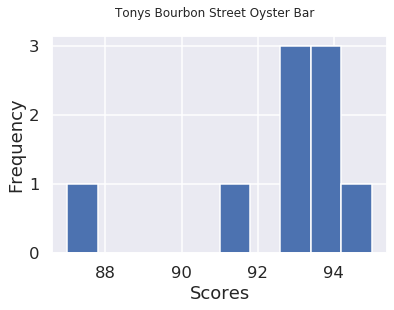

In [6]:
# See all scores for a specific restaurant
def get_hist(restaurant_name):
    df_inspec['score'][(df_inspec['name'] == restaurant_name)].hist()
    pl.suptitle(restaurant_name)
    plt.xlabel('Scores')
    plt.ylabel('Frequency')

        
# Example: Use function for any restaurant out of the 317
get_hist(restaurants[300])

This visualization shows that most restaurants in this dataframe score relatively high, with many scores over 90.

We then create a method that can plot a restaurant's scores over time

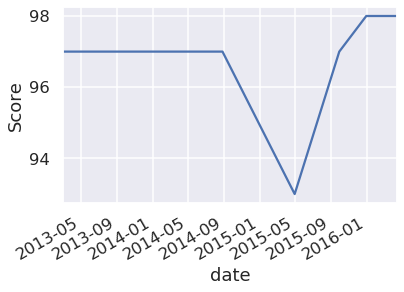

In [7]:
# Set index of df to the dates
df_inspec.set_index('date', inplace=True)

def get_plot(restaurant_name):   
    df_inspec['score'][(df_inspec['name'] == restaurant_name)].plot()
    plt.ylabel('Score')

# Example: Use function for any restaurant out of the 317
get_plot(restaurants[0])

From these visualizations, it seems there is an upward trend in scores overall.

Display all scores over time for all restaurants

Text(0, 0.5, 'Score')

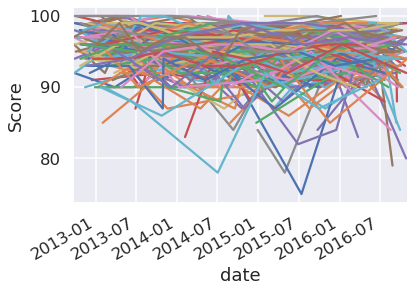

In [8]:
for x in range(317):
    get_plot(restaurants[x])
plt.ylabel('Score')

This shows the variability of scores over time but the trend does seem overall stable or upwards.

Lastly, we obtain the score differences from the earliest date to the most recent date:

In [9]:
# Make copy of date index
df_inspec['date'] = df_inspec.index

# Get max and min date for each name
df_inspec['max date'] = df_inspec.groupby('name').date.transform('max')
df_inspec['min date'] = df_inspec.groupby('name').date.transform('min')


# List storing score differences
changes = []

# Method for getting difference of an inputted restaurant
def get_diff(restaurant_name):        
        temp_df = df_inspec[df_inspec['name'] == restaurant_name]

        max_date = temp_df['score'][(temp_df['max date'] == temp_df['date'])]
        min_date = temp_df['score'][(temp_df['min date'] == temp_df['date'])]
        
        # Get score from index 0 of series
        changes.append(max_date[0] - min_date[0])

# Get difference of all restaurants
for x in range(317):
    get_diff(restaurants[x])

# Get mean of all differences
mean = sum(changes) / len(changes) 
print(mean)

-0.6025236593059937


# Ethics & Privacy

While not all health inspection scores are avaliable online to the public, we can use the ones that are avaliable to the general public. I believe there are no privacy concerns since the names of the restaurants are not included in the dataset, and there are no information that can suggest a particular dataset is a specific restaurant. 

There could be potential biases in the dataset since we are only using health inspection scores avaliable to us. This does not cover all possible restaurants in the United States, but since health inspections are an official business and are required for all restaurants, there should be no biases based on certain populations or human biases. One thing we must consider is potential biases during health inspections themselves (such as giving ethnic restaurants lower scores based on pre-existing biases towards them), but since we are taking the data from the entire United States over the past 10 years, those biases should be minimal based on the coverage of our ideal dataset. 

# Conclusion & Discussion

In this project, I investigated the average change in score in repeat inspections for restaurants. I used the inspections.csv dataset and sorted it by restaurant name and inspection date so that I could get a better picture of how inspection scores changed over time for each individual restaurant. I then visualized each restaurant as a histogram and a plot. To obtain the change in score from the first inspection to the most recent one, I obtained the minimum and maximum inspection date for each restaurant and subtracted their scores. After storing all these differences in a list, I found the mean of these differences to be approximately -0.60.

This was suprising because I expected restaurant inspection scores to increase overall over time. From the visualizations, it seemed there was an upwards trend in score, but the overall average difference was still negative. This result leads me to conclude that repeat inspections do not have a significant affect on the restaurants score; in fact, with deeper analysis I could possibly conclude that there is a negative correlation. 

This project could be delved into further if I had more time. I had trouble obtaining the actual slope of my plots which is why I decided to compare the overall difference, but finding the slope would be a more accurate representation of how scores changed over time. The project could have also looked into whether passing and failing scores affected any of the other variables. The impact of this work on society is to reveal that multiple restaurant inspections don't neccessarily affect the score much, which is useful for consumers to keep in mind as it may affect their health whenever they eat out.